# What is this notebook about

This notebook builds upon the notebooks ``` spacenet6_masking.ipynb ``` and ``` spacenet6_resize.ipynb ```

``` spacenet6_masking.ipynb ``` is used to generate all the masks for all 3401 training images, using only the PAN images and geojson_buildings files. These masks will be the same regardless of the original data format, hence it is a run-once-and-forget

``` spacenet6_resize.ipynb ``` is used to resize images to the appropriate size and data format, depending on the output resolution wanted for training. Most research papers utilise a 256x256 resolution as a sufficient size for unet applications. This should be run before running this notebook to set up the files needed



This notebook shall be used for resizing all image input format. The available input formats will be
* PAN
* PS-RGB
* PS-RGBNIR
* RGBNIR
* SAR-Intensity

After resizing, these images will be saved to reduce the need for further processing. They will be saved in their original channel format, as a .tif file 

# Setup COLAB and imports

Mount drive to gain access to files

In [130]:
''' Used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = '/content/gdrive/My Drive/Colab Notebooks'

Mounted at /content/gdrive


Installations required

In [131]:
! pip install rasterio

Imports required

In [132]:
''' dealing with .tif files '''
import rasterio
from rasterio.plot import show, reshape_as_raster, reshape_as_image

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' core '''
import numpy as np

''' utilities '''
from tqdm import tqdm
import copy

''' image processing '''
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Global

Constants and lookups

For reference the various image types are as such (amax is a rough gauge):

```
type             shape                dtype       gauge of max value    gauge of min value
PAN              (1, 900, 900)        uint16      1844                  0
PS-RGB           (3, 900, 900)        uint8       255                   0
PS-RGBNIR        (4, 900, 900)        uint16      2047                  0
RGBNIR           (4, 450, 450)        uint16      2047                  0
SAR-Intensity    (4, 900, 900)        float32     82.70110321044922     0.0
```



In [133]:
''' get the same sequence for random set every time '''
seed = 42
np.random.seed = seed
# tf.seed = seed                                             

''' lookup - define image channels for each image type '''
IMG_TYPE_LOOKUP = {
    'PAN': {'channels': 1, 'dtype': np.uint16}, 
    'PS-RGB': {'channels': 3, 'dtype': np.uint8}, 
    'PS-RGBNIR': {'channels': 4, 'dtype': np.uint16}, 
    'RGBNIR': {'channels': 4, 'dtype': np.uint16}, 
    'SAR-Intensity': {'channels': 4, 'dtype': np.float32}, 
}

Setting the output image specifications

In [156]:
IMG_TYPE = 'SAR-Intensity'                                                          # change this
IMG_WIDTH = 256                                                                 # change this
IMG_HEIGHT = 256                                                                # change this
IMG_CHANNELS = IMG_TYPE_LOOKUP[IMG_TYPE]['channels']
IMG_DTYPE_SRC = IMG_TYPE_LOOKUP[IMG_TYPE]['dtype']
IMG_DTYPE = np.uint8               

We will be setting the amount of data that we want to use
* There are 3401 images for each image type
* The actual spacenet6 "test folder" has only uneseen SAR-Intensity data

Therefore for training purposes, we will pull out our own "test data" from the training set. All the 3401 images will be prepared as training images, but the test set size will be specified, and the 'test folder' will be purged and written into each time we require

The SIZE_TRAIN and SIZE_TEST specified here will be used to return a random arrangement of images to the calling function

In [157]:
SIZE_ALL = 3401
SIZE_TRAIN = 100 #3200                                                               # change this
SIZE_TEST = 10 #201                                                                 # change this, keep it small

Set the original data source folder

In [158]:
''' obtain all the images and mask that have been prepared '''
PATH_SRC = Path(root_dir + '/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam')
PATH_SRC_IMAGE = PATH_SRC/IMG_TYPE
PATH_SRC_MASK = PATH_SRC/'_mask'

Set the target data folder

In [159]:
''' change in accordance to the image type and dimensions '''
COMBI = IMG_TYPE + '_' + str(IMG_WIDTH) + 'x' + str(IMG_HEIGHT)

''' set the directories for this combination '''
PATH_DATA = Path(root_dir + '/spacenet6/spacenet6_data/' + COMBI)
PATH_DATA.mkdir(parents=True, exist_ok=True)

PATH_IMAGE = PATH_DATA/'image'
PATH_IMAGE.mkdir(parents=True, exist_ok=True)

PATH_MASK = PATH_DATA/'mask'
PATH_MASK.mkdir(parents=True, exist_ok=True)

# Helper functions

Available functions:
* ``` resize_and_save(img_src_path: PosixPath, img_fname: str, img_save_path: PosixPath): None ```
* ``` plot_XY(plotname: str, X: np.ndarray[SIZE], Y: np.ndarray[SIZE], X_name: str, Y_name: str) ```
* ``` plot_XY_preds(plotname: str, X: np.ndarray[SIZE], Y: np.ndarray[SIZE], P: np.ndarray[SIZE], X_name: str, Y_name: str, P_name: str) ```

In [160]:
def resize_and_save(img_src_path, img_fname, img_save_path):
  img = rasterio.open(img_src_path/img_fname)

  ''' use the metadata from the original image '''
  transform = img.transform
  meta = img.meta.copy()

  ''' resize the image '''
  resized_img = img.read()
  # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))
  resized_img = reshape_as_image(resized_img)
  # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))

  resized_img = tf.image.resize(resized_img, [IMG_HEIGHT, IMG_WIDTH], method='nearest', preserve_aspect_ratio=True, antialias=True)
  resized_img = reshape_as_raster(resized_img)
  # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))

  ''' update metadata with new size '''
  meta.update({"transform": transform,
              "height": resized_img.shape[1],
              "width": resized_img.shape[2]
              })

  ''' write the resized image to a new geotiff '''
  with rasterio.open(img_save_path/img_fname, 'w', **meta) as dst:
    dst.write(resized_img)

In [161]:
def plot_XY(plotname, X, Y, X_name, Y_name):
  ix = np.random.randint(0, len(X))
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(21,7))
  show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  plt.show()

In [162]:
def plot_XY_preds(plotname, X, Y, P, X_name, Y_name, P_name):
  ix = np.random.randint(0, len(X))
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,7))
  show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  show(reshape_as_raster(P[ix]), ax=ax3, title=P_name)
  plt.show()


# Resizing images

Verify contents in source directory are present and assign to iterator

In [ ]:
src_image_ids = next(os.walk(PATH_SRC_IMAGE))[2]
src_image_ids.sort()
print('len(src_image_ids): {}'.format(len(src_image_ids)))
print(src_image_ids[:5])

src_mask_ids = next(os.walk(PATH_SRC_MASK))[2]
src_mask_ids.sort()
print('len(src_mask_ids): {}'.format(len(src_mask_ids)))
print(src_mask_ids[:5])

len(src_image_ids): 3401
['SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190804111224_20190804111453_tile_8679.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190804111224_20190804111453_tile_8681.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190804111224_20190804111453_tile_8683.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190804111224_20190804111453_tile_8685.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190804111224_20190804111453_tile_8687.tif']
len(src_mask_ids): 3401
['SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.tif', 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8681.tif', 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8683.tif', 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8685.tif', 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8687.tif']


The filenames are well-formed, hence after sorting we can run things through indexes safely. We will resize and save all 3401 images in the source folder, and save into the train/mask folder

In [ ]:
print('Resizing image')
for n, id in tqdm(enumerate(src_image_ids), total=len(src_image_ids), position=0, leave=True):
  resize_and_save(PATH_SRC_IMAGE, id, PATH_IMAGE)
print('Finished resizing image')

print('Resizing mask')
for n, id in tqdm(enumerate(src_mask_ids), total=len(src_mask_ids), position=0, leave=True):
  resize_and_save(PATH_SRC_MASK, id, PATH_MASK)
print('Finished resizing mask')

  0%|          | 0/3401 [00:00<?, ?it/s]

Resizing image


  0%|          | 0/3401 [00:00<?, ?it/s]

Finished resizing image
Resizing mask


100%|██████████| 3401/3401 [48:46<00:00,  1.16it/s]

Finished resizing mask


# Create the actual train and test set to be used


Generate the indexes that we will be using

In [163]:
all_idx = np.arange(SIZE_ALL)

train_idx = np.random.choice(all_idx, SIZE_TRAIN, replace=False)
train_idx.sort()

all_idx_2 = np.setdiff1d(all_idx, train_idx)

test_idx = np.random.choice(all_idx_2, SIZE_TEST, replace=False)
test_idx.sort()

Traverse to get all the ids (file names) that we want

* X: image file
* Y: mask file

In [164]:
all_img_ids = next(os.walk(PATH_IMAGE))[2]
all_img_ids.sort()
all_img_ids = np.array(all_img_ids)

all_mask_ids = next(os.walk(PATH_MASK))[2]
all_mask_ids.sort()
all_mask_ids = np.array(all_mask_ids)

X_train_ids = all_img_ids[train_idx]
X_train_ids.sort()
Y_train_ids = all_mask_ids[train_idx]
Y_train_ids.sort()

X_test_ids = all_img_ids[test_idx]
X_test_ids.sort()
Y_test_ids = all_mask_ids[test_idx]
Y_test_ids.sort()


print(len(all_img_ids))
print(all_img_ids[:3])
print(len(all_mask_ids))
print(all_mask_ids[:3])
print(len(X_train_ids))
print(X_train_ids[:3])
print(len(Y_train_ids))
print(Y_train_ids[:3])
print(len(X_test_ids))
print(X_test_ids[:3])
print(len(Y_test_ids))
print(Y_test_ids[:3])

3401
['SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804111224_20190804111453_tile_8679.tif'
 'SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804111224_20190804111453_tile_8681.tif'
 'SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804111224_20190804111453_tile_8683.tif']
3401
['SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.tif'
 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8681.tif'
 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8683.tif']
100
['SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804111224_20190804111453_tile_8695.tif'
 'SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804114132_20190804114404_tile_10814.tif'
 'SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804114647_20190804114904_tile_6250.tif']
100
['SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8695.tif'
 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804114132_20190804114404_tile_10814.tif'
 'SN6_Train_AOI_11_Rotterdam_

Prepare numpy arrays to store converted image and mask files. Image files will need to be converted to IMG_DTYPE (global), and mask files will be converted to np.bool

In [165]:
X_train = np.zeros((len(X_train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE_SRC) # dtype=IMG_DTYPE
Y_train = np.zeros((len(Y_train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
X_test = np.zeros((len(X_test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE_SRC) #  dtype=IMG_DTYPE
Y_test = np.zeros((len(Y_test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('X_train', X_train.shape, X_train.dtype)
print('Y_train', Y_train.shape, Y_train.dtype)
print('X_test', X_test.shape, X_test.dtype)
print('Y_test', Y_test.shape, Y_test.dtype)

X_train (100, 256, 256, 4) float32
Y_train (100, 256, 256, 1) bool
X_test (10, 256, 256, 4) float32
Y_test (10, 256, 256, 1) bool


Casting the images and masks into the correct data type

In [166]:
print('formatting training images')
for n, id in tqdm(enumerate(X_train_ids), total=len(X_train_ids), position=0, leave=True):
  img = rasterio.open(PATH_IMAGE/id).read()
  img = reshape_as_image(img)
  X_train[n] = img
print('Finished formatting training images')

print('formatting training masks')
for n, id in tqdm(enumerate(Y_train_ids), total=len(Y_train_ids), position=0, leave=True):
  img = rasterio.open(PATH_MASK/id).read()
  img = reshape_as_image(img)
  img = img.astype(np.bool) 
  Y_train[n] = img
print('Finished formatting training masks')

print('formatting test images')
for n, id in tqdm(enumerate(X_test_ids), total=len(X_test_ids), position=0, leave=True):
  img = rasterio.open(PATH_IMAGE/id).read()
  img = reshape_as_image(img)
  X_test[n] = img
print('Finished formatting test images')

print('formatting test masks')
for n, id in tqdm(enumerate(Y_test_ids), total=len(Y_test_ids), position=0, leave=True):
  img = rasterio.open(PATH_MASK/id).read()
  img = reshape_as_image(img)
  img = img.astype(np.bool) 
  Y_test[n] = img
print('Finished formatting test masks')

  0%|          | 0/100 [00:00<?, ?it/s]

formatting training images


  0%|          | 0/100 [00:00<?, ?it/s]

Finished formatting training images
formatting training masks


  0%|          | 0/10 [00:00<?, ?it/s]

Finished formatting training masks
formatting test images


  0%|          | 0/10 [00:00<?, ?it/s]

Finished formatting test images
formatting test masks


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]

Finished formatting test masks


Verify the image conversion, and inspect the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 74
train  set


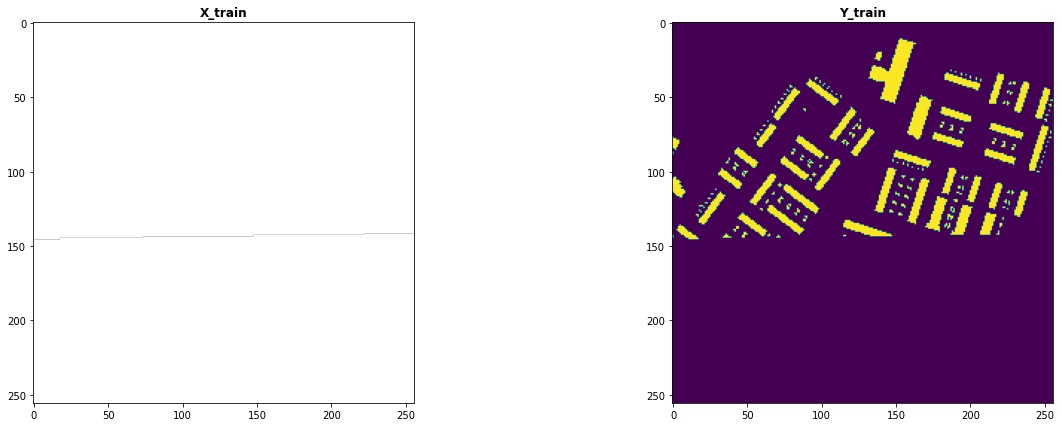

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 76
train  set


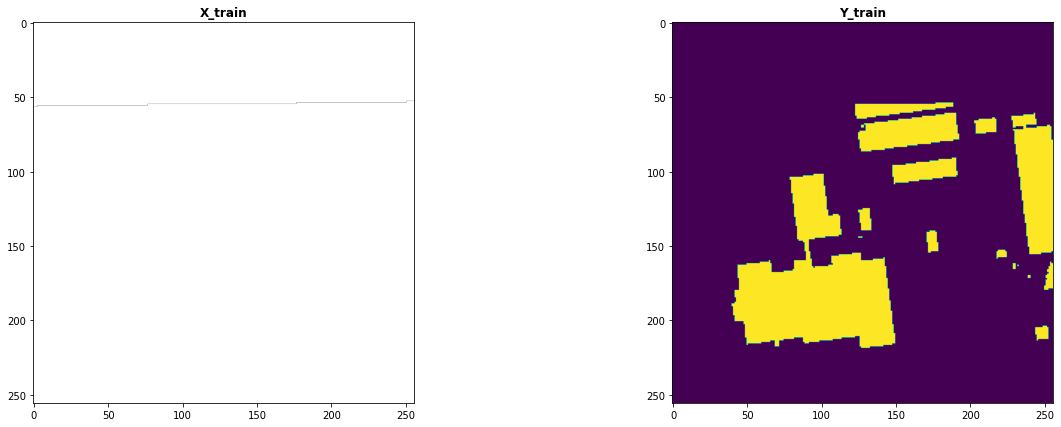

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 9
test  set


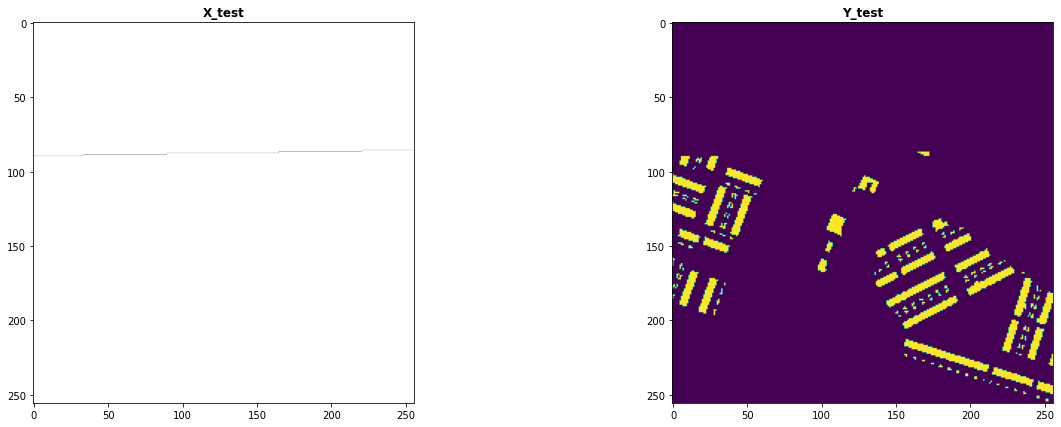

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 9
test  set


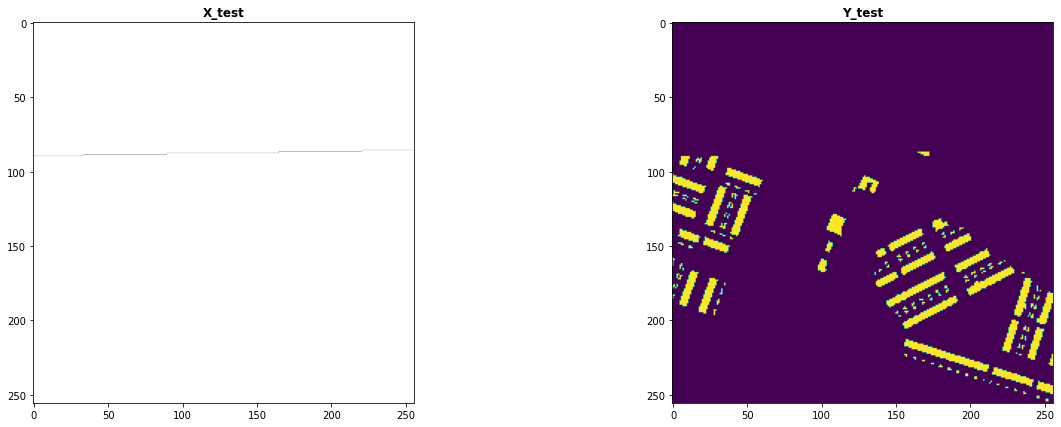

In [167]:
plot_XY('train', X_train, Y_train, 'X_train', 'Y_train')
plot_XY('train', X_train, Y_train, 'X_train', 'Y_train')
plot_XY('test', X_test, Y_test, 'X_test', 'Y_test')
plot_XY('test', X_test, Y_test, 'X_test', 'Y_test')

# Create the unet model

In [168]:
! pip install keras_unet
! pip install focal-loss

In [169]:
from keras import backend as K
from focal_loss import BinaryFocalLoss
from keras_unet.models import satellite_unet

In [170]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [171]:
model = satellite_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=2), metrics=['acc',f1_m,precision_m, recall_m])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 256, 256, 64) 2368        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_186 (BatchN (None, 256, 256, 64) 256         conv2d_168[0][0]                 
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 256, 256, 64) 36928       batch_normalization_186[0][0]    
____________________________________________________________________________________________

In [172]:
# Model checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_spacenet6_keras_3.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=3, callbacks=callbacks)

Epoch 1/3
6/6 [==============================] - 267s 44s/step - loss: 0.2577 - acc: 0.7064 - f1_m: 0.1145 - precision_m: 0.1203 - recall_m: 0.3045 - val_loss: 0.0757 - val_acc: 0.9405 - val_f1_m: 0.0210 - val_precision_m: 0.0259 - val_recall_m: 0.0177
Epoch 2/3
6/6 [==============================] - 263s 44s/step - loss: 0.0799 - acc: 0.9059 - f1_m: 0.0993 - precision_m: 0.1851 - recall_m: 0.0874 - val_loss: 0.0463 - val_acc: 0.9456 - val_f1_m: 0.1652 - val_precision_m: 0.1852 - val_recall_m: 0.1491
Epoch 3/3
6/6 [==============================] - 262s 44s/step - loss: 0.0671 - acc: 0.9138 - f1_m: 0.1090 - precision_m: 0.2242 - recall_m: 0.0756 - val_loss: 0.0502 - val_acc: 0.9619 - val_f1_m: 0.0122 - val_precision_m: 0.0934 - val_recall_m: 0.0065


In [173]:
# model.save(PATH_DATA/'model_satellite_unet_25_epoch')

In [174]:
''' split train, val 90-10. validation_split takes the percentage from the back '''
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 1ms/step


# Check results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 50
train preds  set


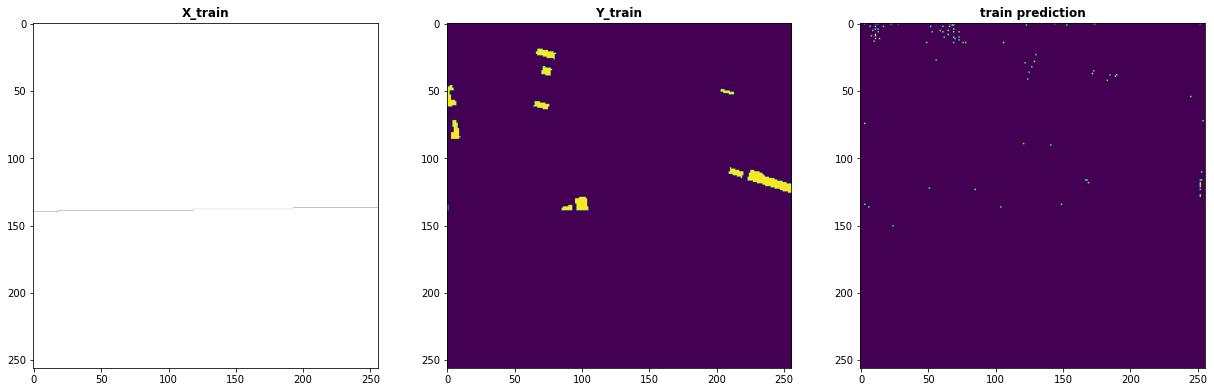

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 6
val preds  set


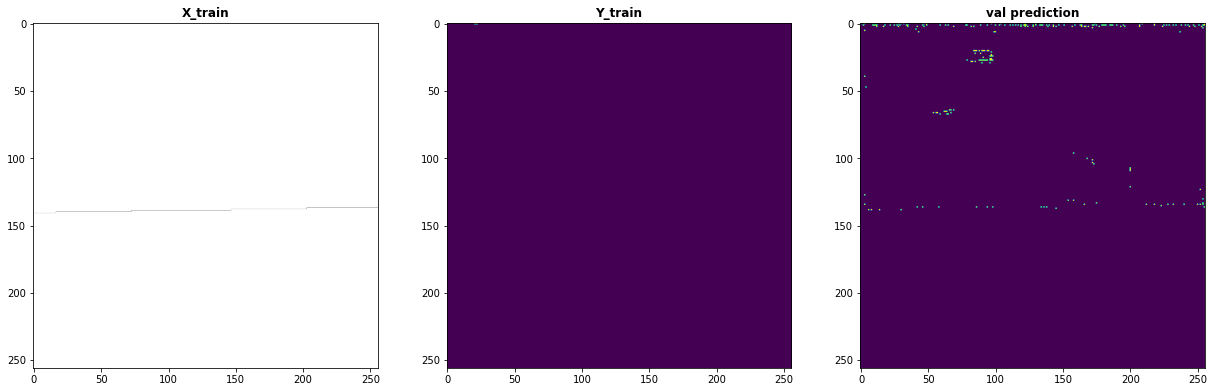

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 3
test preds  set


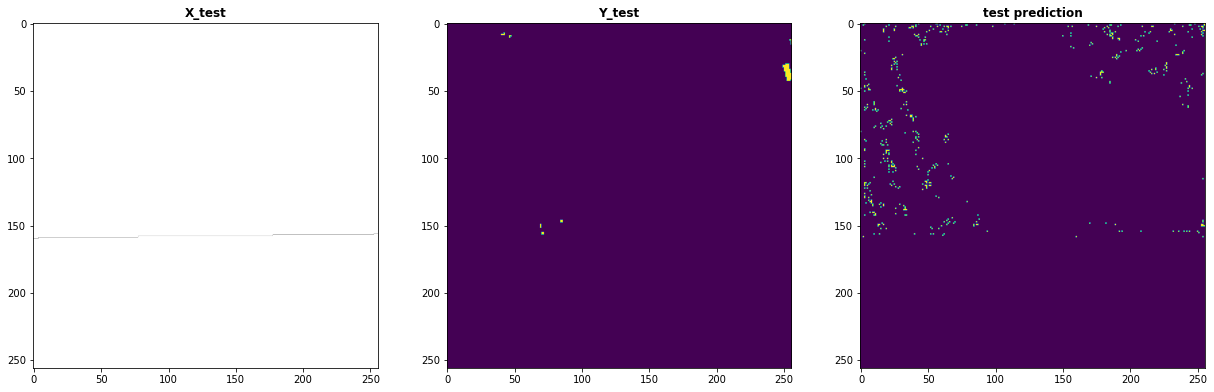

In [175]:
plot_XY_preds('train preds', X_train[:int(X_train.shape[0]*0.9)], Y_train[:int(X_train.shape[0]*0.9)], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[int(X_train.shape[0]*0.9):], Y_train[int(X_train.shape[0]*0.9):], preds_val_t, 'X_train', 'Y_train', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')

# TRIAL

### Type casting to model

In [ ]:
a = rasterio.open(PATH_IMAGE/X_train_ids[0]).read()
a = reshape_as_image(a)
print(a.shape, a.dtype, np.amax(a))
a = a.astype(IMG_DTYPE)
print(a.shape, a.dtype, np.amax(a))

(256, 256, 1) uint16 1844
(256, 256, 1) uint8 255


In [ ]:
a = rasterio.open(PATH_MASK/Y_test_ids[0]).read()
a = a.astype(np.bool)
# a = reshape_as_image(a)
print(a.shape, a.dtype, np.amax(a))

(1, 256, 256) bool True


In [ ]:
np.can_cast(np.float32, np.uint8)

False

In [ ]:
np.can_cast(np.uint16, np.uint8)

False

### Visualize an image

In [ ]:
type_img = 'PS-RGBNIR'
resize_and_save(PATH_SRC/type_img, 'SN6_Train_AOI_11_Rotterdam_' + type_img + '_20190804111224_20190804111453_tile_8679.tif', PATH_SRC)

(4, 900, 900) uint16 amax: 2047 amin: 0
(900, 900, 4) uint16 amax: 2047 amin: 0
(4, 256, 256) uint16 amax: 2047 amin: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 256, 256) uint16 amax: 2047 amin: 0


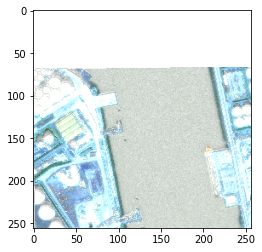

In [ ]:
fname = 'SN6_Train_AOI_11_Rotterdam_' + type_img + '_20190804111224_20190804111453_tile_8679.tif'
img = rasterio.open(PATH_SRC/fname).read()
print(img.shape, img.dtype, 'amax: {}'.format(np.amax(img)), 'amin: {}'.format(np.amin(img)))
show(img)

### Look at all the image types

In [ ]:
PAN_img = rasterio.open(PATH_SRC/'PAN/SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8679.tif').read()
print(PAN_img.shape, PAN_img.dtype, 'amax: {}'.format(np.amax(PAN_img)), 'amin: {}'.format(np.amin(PAN_img)))

(1, 900, 900) uint16 amax: 1844 amin: 0


In [ ]:
PS_RGB_img = rasterio.open(PATH_SRC/'PS-RGB/SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8679.tif').read()
print(PS_RGB_img.shape, PS_RGB_img.dtype, 'amax: {}'.format(np.amax(PS_RGB_img)), 'amin: {}'.format(np.amin(PS_RGB_img)))

(3, 900, 900) uint8 amax: 255 amin: 0


In [ ]:
PS_RGBNIR_img = rasterio.open(PATH_SRC/'PS-RGBNIR/SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190804111224_20190804111453_tile_8679.tif').read()
print(PS_RGBNIR_img.shape, PS_RGBNIR_img.dtype, 'amax: {}'.format(np.amax(PS_RGBNIR_img)), 'amin: {}'.format(np.amin(PS_RGBNIR_img)))

(4, 900, 900) uint16 amax: 2047 amin: 0


In [ ]:
RGBNIR_img = rasterio.open(PATH_SRC/'RGBNIR/SN6_Train_AOI_11_Rotterdam_RGBNIR_20190804111224_20190804111453_tile_8679.tif').read()
print(RGBNIR_img.shape, RGBNIR_img.dtype, 'amax: {}'.format(np.amax(RGBNIR_img)), 'amin: {}'.format(np.amin(RGBNIR_img)))

(4, 450, 450) uint16 amax: 2047 amin: 0


In [ ]:
SAR_Itensity_img = rasterio.open(PATH_SRC/'SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804111224_20190804111453_tile_8679.tif').read()
print(SAR_Itensity_img.shape, SAR_Itensity_img.dtype, 'amax: {}'.format(np.amax(SAR_Itensity_img)), 'amin: {}'.format(np.amin(SAR_Itensity_img)))

(4, 900, 900) float32 amax: 82.70110321044922 amin: 0.0
